Q1: Vapor-liquid equilibria data

Least Square Formulation

$\sum \limits _{i=1} ^{11} (\hat{P}_{i}-P_{i})^2 $

C:\Users\mauli\AppData\Local\Temp/ipykernel_213748/2557107225.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x2 = torch.tensor(x2, requires_grad = False)


tensor([1.9584, 1.6892], requires_grad=True)
0.6701940012294854


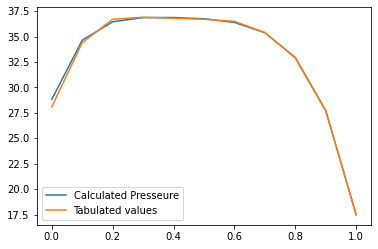

In [5]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as mpl

#Given values
T = 20
p_sat_w = 10 ** (8.07131 - (1730.63/(T+233.426)))
p_sat_diox = 10 ** (7.43155 - (1554.679/(T + 240.337)))

# table values
x1 = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) #for water
x1 = torch.tensor(x1, requires_grad = False)
x2 = 1 - (x1) # for dioxane 
x2 = torch.tensor(x2, requires_grad = False)
p_tab = np.array([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])
p_tab = torch.tensor(p_tab, requires_grad = False)

A = Variable(torch.tensor([1.0,1.0]), requires_grad = True) # Guess/Initial values for A12 and A21

step = 0.001

for i in range(1000):
    p_eqn = (x1 * (torch.exp(A[0] * (((A[1]*x2)/((A[0]*x1)+(A[1]*x2)))**2))) * p_sat_w) + (x2 * (torch.exp(A[1] * (((A[0]*x1)/((A[0]*x1)+(A[1]*x2)))**2))) * p_sat_diox)
    
    error = ((p_eqn - p_tab)**2) #penalizing eorror by squaring it
    error = error.sum()
    error.backward() # calculate gradient
    
    with torch.no_grad():
#         A = A - (step * A.grad)
        A.sub_(A.grad * step)
        A.grad.zero_()
print(A)
print(error.data.numpy())

p_eqn = p_eqn.detach().numpy()
p_tab = p_tab.detach().numpy()
x1 = x1.detach().numpy()
mpl.plot(x1,p_eqn, label = 'Calculated Presseure')
mpl.plot(x1,p_tab, label = 'Tabulated values')
mpl.legend()
mpl.show()

The calculated values follow the tabulated values very closely. The error is quite small and hence the prediction is quite sound and can be applied.

Q2: Bayesian Optimization

From https://github.com/fmfn/BayesianOptimization

In [12]:
def black_box_function(x1, x2):
    """Function with unknown internals we wish to maximize.

    This is just serving as an example, for all intents and
    purposes think of the internals of this function, i.e.: the process
    which generates its output values, as unknown.
    """
    return -(((4 - (2.1*x1*x1) + ((x1**4)/3))*(x1**2))+(x1*x2)+((-4+(4*x2*x2))*(x2**2))) #inverting caause we have taken maximize at the end

from bayes_opt import BayesianOptimization # independent function

# Bounded region of parameter space
pbounds = {'x1': (-3, 3), 'x2': (-2, 2)}

optimizer = BayesianOptimization(f = black_box_function, pbounds = pbounds, random_state = 1)
optimizer.maximize(init_points = 50, n_iter = 100)

# more iterations and points get more closer results.

print(optimizer.max)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

|   iter    |  target   |    x1     |    x2     |
-------------------------------------------------
|  1        |  0.265    | -0.4979   |  0.8813   |
|  2        | -110.1    | -2.999    | -0.7907   |
|  3        | -26.91    | -2.119    | -1.631    |
|  4        | -2.856    | -1.882    | -0.6178   |
|  5        | -1.054    | -0.6194   |  0.1553   |
|  6        |  0.5211   | -0.4848   |  0.7409   |
|  7        | -11.28    | -1.773    |  1.512    |
|  8        | -66.76    | -2.836    |  0.6819   |
|  9        | -0.5377   | -0.4962   |  0.2348   |
|  10       | -12.02    | -2.158    | -1.208    |
|  11       | -40.85    |  1.804    |  1.873    |
|  12       | -0.5433   | -1.119    |  0.7693   |
|  13       | -28.42    |  2.258    |  1.578    |
|  14       | -60.72    | -2.49     | -1.844    |
|  15       | -12.29    | -1.981    |  1.513    |
|  16       | -18.1     | -2.41     | -0.3156   |
|  17       | -54.18    |  2.747    |  0.1327   |
|  18       | -0.547    |  1.151    | -0.7379   |


|  100      | -0.02426  |  0.2951   | -0.2501   |
|  101      | -0.5169   |  0.8481   | -0.5855   |
|  102      | -0.504    | -0.3647   | -0.04657  |
|  103      |  0.991    |  0.1114   | -0.7797   |
|  104      | -0.1206   |  1.767    | -0.6203   |
|  105      |  0.434    |  0.4531   | -0.5872   |
|  106      |  0.6439   | -0.2382   |  0.8916   |
|  107      | -3.766    |  1.993    |  0.06825  |
|  108      |  0.4695   |  0.2624   |  0.7878   |
|  109      | -1.101    | -1.698    |  0.334    |
|  110      | -4.134    | -2.092    |  0.3306   |
|  111      | -0.6751   |  0.9327   | -0.9056   |
|  112      | -0.1163   | -0.2449   | -0.9505   |
|  113      |  0.1356   |  1.695    | -0.876    |
|  114      | -0.2551   | -0.6479   |  0.5017   |
|  115      |  0.1098   | -0.4049   | -0.7135   |
|  116      |  0.6571   | -0.08581  |  0.4509   |
|  117      |  0.07723  | -1.689    |  0.6771   |
|  118      |  0.6626   | -0.318    |  0.5635   |
|  119      |  0.9623   |  0.03303  |  0.6686   |
